<a href="https://colab.research.google.com/github/PolMix/nems_ai/blob/main/Neural%20ML/shap_neural_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lib import

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import seaborn as sns
from copy import deepcopy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

In [18]:
# Модели
import torch
import torch.nn as nn

# Метрики качества
from time import time

from sklearn.metrics import mean_squared_error
from torch.nn.functional import mse_loss

!pip install lion-pytorch
from lion_pytorch import Lion

import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install torchmetrics
from torchmetrics import R2Score

from IPython.display import clear_output

try:
    import shap
except ModuleNotFoundError:
    !pip install shap
    clear_output()
    import shap

!pip install torcheval
from torcheval.metrics.functional import r2_score

# Обработка датасета
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# Нормировка датасета
from sklearn.preprocessing import RobustScaler, StandardScaler

# Удобства
from tqdm import tqdm

# Шедуллер
from torch.optim.lr_scheduler import ReduceLROnPlateau

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Фиксация сида:

In [3]:
import random

def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

set_random_seed(42)

Перенос модели на GPU:

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Скачивание данных и скриптов

Загружаем датасет с GitHub:

In [5]:
import zipfile
import os

!wget --no-check-certificate \
    "https://github.com/PolMix/nems_ai/archive/refs/heads/main.zip" \
    -O "/tmp/data.zip"


zip_ref = zipfile.ZipFile('/tmp/data.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2023-06-13 11:51:28--  https://github.com/PolMix/nems_ai/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/PolMix/nems_ai/zip/refs/heads/main [following]
--2023-06-13 11:51:28--  https://codeload.github.com/PolMix/nems_ai/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.112.10
Connecting to codeload.github.com (codeload.github.com)|140.82.112.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/data.zip’

/tmp/data.zip           [      <=>           ]  16.11M  6.25MB/s    in 2.6s    

2023-06-13 11:51:31 (6.25 MB/s) - ‘/tmp/data.zip’ saved [16897120]



In [6]:
%cd '/tmp/nems_ai-main/Data Processed'
filename = 'Dataset_Processed.csv'
df = pd.read_csv(filename)
df = df.drop(columns='Unnamed: 0')
df.head()

/tmp/nems_ai-main/Data Processed


,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),Pretension (Pa),M1 Eigenfrequency (Hz),M1 Quality factor,...,M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 Noise (kg^2/s^3),M3 TED (W),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 Noise (kg^2/s^3),M4 TED (W)
0,10.666186,759.454713,192.911166,46.497924,19.089801,465.822644,28.323179,9.003567e+08,6.415102e+07,1.336133e+04,...,2.909667e+08,1.143351e+04,2.560363e-15,6.037978e-22,3.409430e-12,3.964520e+08,1.013999e+04,8.780197e-16,3.181145e-22,4.959458e-12
1,105.195552,890.696186,209.252268,37.407275,3.716553,314.636835,30.305477,5.090849e+08,2.569354e+06,7.177442e+06,...,8.224139e+06,5.740452e+06,3.281744e-14,8.720428e-28,1.367533e-11,1.152226e+07,5.003229e+06,3.291971e-14,1.406151e-27,1.583936e-11
2,10.310316,221.113532,195.903798,37.079461,0.027053,251.500693,26.675832,6.351363e+08,3.353110e+07,2.675673e+06,...,1.267642e+08,1.891218e+06,7.206070e-16,6.788349e-28,2.254001e-12,1.923697e+08,1.709827e+06,7.147747e-16,1.130223e-27,2.477637e-12
3,18.683573,282.662136,207.614117,18.750307,0.496423,172.245797,2.647445,0.000000e+00,1.049078e+07,8.772643e+06,...,4.475571e+07,8.332783e+06,1.623836e-15,6.849769e-28,2.943955e-12,7.057576e+07,8.000998e+06,1.616668e-15,1.119973e-27,3.081568e-12
4,121.747842,991.550766,102.506945,29.297485,2.037235,415.471216,18.419812,8.374213e+08,2.649739e+06,7.314592e+06,...,8.269131e+06,6.082613e+06,2.259615e-14,2.331664e-28,2.518650e-11,1.138111e+07,5.405428e+06,2.267905e-14,3.624442e-28,2.982471e-11


# Подготовка данных

Делаем несколько действий:
- разбиваем датасет на тренировочную + валидационную часть и тестовую часть
- разбиваем трен-вал датасет на X и Y данные
- разбиваем тест датасет на X и Y данные

In [7]:
len_test = 0.2 # доля объектов на тренировку и валидацию из изначального датасета
len_val = 0.2 # доля объектов на валидацию из трен-вал датасета

mode_number = 4

df_trainval, df_test = train_test_split(df, test_size=len_test, random_state=42, shuffle=True)
df_train, df_val = train_test_split(df_trainval, test_size=len_val, random_state=42, shuffle=True)

Разбиение подвыборок на X и Y данные:

In [8]:
%cd '/tmp/nems_ai-main/Scripts'
from dataset_preprocessing_pandas import split_df

x_train, y_train = split_df(df_train, num_common=8)
x_val, y_val = split_df(df_val, num_common=8)
x_test, y_test = split_df(df_test, num_common=8)

print('Dataset has been split into parts with the following shapes:')
print(f'x_train: {x_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'x_val: {x_val.shape}')
print(f'y_val: {y_val.shape}')
print(f'x_test: {x_test.shape}')
print(f'y_test: {y_test.shape}')

/tmp/nems_ai-main/Scripts
Dataset has been split into parts with the following shapes:
x_train: (3141, 8)
y_train: (3141, 20)
x_val: (786, 8)
y_val: (786, 20)
x_test: (982, 8)
y_test: (982, 20)


In [9]:
x_test.head()

,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),Pretension (Pa)
4153,49.308200,782.896481,188.132818,26.635533,39.776275,218.106779,14.971359,3.142405e+08
3543,192.137428,518.376180,207.654824,15.361588,14.690520,358.705745,17.274668,0.000000e+00
907,58.299798,519.390602,200.345532,16.901881,264.175611,263.652628,23.487618,0.000000e+00
2522,65.228068,534.583721,199.844154,17.919077,10.055709,590.683389,30.865407,5.533608e+08
3107,419.836754,346.292481,209.354864,44.989361,1.196841,283.956739,17.091576,3.264575e+08


In [10]:
y_train.head()

,M1 Eigenfrequency (Hz),M1 Quality factor,M1 Effective mass (kg),M1 Noise (kg^2/s^3),M1 TED (W),M2 Eigenfrequency (Hz),M2 Quality factor,M2 Effective mass (kg),M2 Noise (kg^2/s^3),M2 TED (W),M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 Noise (kg^2/s^3),M3 TED (W),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 Noise (kg^2/s^3),M4 TED (W)
3781,8.234588e+05,2.205309e+06,3.358069e-14,1.007442e-29,2.962872e-12,1.652589e+06,2.179432e+06,3.360062e-14,2.047043e-29,1.705975e-11,2.492992e+06,2.138282e+06,3.363194e-14,3.150402e-29,2.224337e-11,3.350131e+06,1.953502e+06,3.366659e-14,4.638795e-29,2.730320e-11
2200,3.620573e+07,1.264815e+05,1.630021e-15,2.647570e-23,3.616754e-12,8.950608e+07,8.741688e+04,1.780460e-15,1.034411e-22,3.956188e-12,1.634791e+08,6.489439e+04,1.773305e-15,2.534792e-22,4.171862e-12,2.560639e+08,5.143171e+04,1.759506e-15,4.970636e-22,4.369109e-12
4798,4.018177e+06,6.465237e+07,1.022956e-14,9.568429e-31,1.024539e-11,8.167046e+06,6.037550e+07,1.029027e-14,2.094931e-30,1.748103e-11,1.256789e+07,5.489475e+07,1.036000e-14,3.569687e-30,2.206222e-11,1.732588e+07,4.940941e+07,1.039743e-14,5.487195e-30,2.605582e-11
963,4.495736e+07,4.020745e+04,2.375713e-15,3.250626e-26,3.480341e-12,1.127357e+08,3.688876e+04,2.603435e-15,9.736272e-26,3.848615e-12,2.067481e+08,3.532490e+04,2.583663e-15,1.850441e-25,4.200149e-12,3.232575e+08,3.457247e+04,2.556074e-15,2.924626e-25,4.656986e-12
3965,3.016408e+06,1.090949e+09,2.947338e-14,5.105655e-33,9.305841e-13,6.131970e+06,1.006085e+09,2.964966e-14,1.132194e-32,5.494210e-12,9.438750e+06,8.997463e+08,2.985198e-14,1.962020e-32,1.288137e-11,1.301669e+07,8.200638e+08,2.995975e-14,2.979387e-32,1.521141e-11


Выполняем логарифмирование и скейлинг:

In [11]:
from dataset_preprocessing_pandas import Scaler as Scaler

scaler_x = StandardScaler()
scaler_y = StandardScaler()

mode_number = 4
s = Scaler(scaler_x, scaler_y, mode_number)
s.fit(x_train=x_train, y_train=y_train)

x_train, y_train = s.transform(x_train, y_train)
x_val, y_val = s.transform(x_val, y_val)
x_test, y_test = s.transform(x_test, y_test)

In [12]:
y_test.describe()

,M1 Eigenfrequency (Hz),M1 Quality factor,M1 Effective mass (kg),M1 Noise (kg^2/s^3),M1 TED (W),M2 Eigenfrequency (Hz),M2 Quality factor,M2 Effective mass (kg),M2 Noise (kg^2/s^3),M2 TED (W),M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 Noise (kg^2/s^3),M3 TED (W),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 Noise (kg^2/s^3),M4 TED (W)
count,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000
mean,0.008397,-0.014167,-0.006174,0.025109,0.013023,0.008054,-0.013916,-0.006343,0.024551,0.002942,0.007557,-0.014963,-0.006363,0.024660,-0.004944,0.007016,-0.007708,-0.006983,0.021198,-0.008800
std,0.988296,0.961995,0.980944,0.988541,0.984973,0.989626,0.963986,0.980410,0.990055,0.982179,0.990671,0.964596,0.980489,0.990604,0.972298,0.991183,0.973177,0.982377,0.995477,0.968027
min,-2.210503,-2.607106,-2.922469,-2.305750,-3.902680,-2.127390,-2.584861,-2.962526,-2.293187,-4.179475,-2.081414,-2.565005,-2.962160,-2.289673,-4.170642,-2.053933,-2.643954,-2.904239,-2.465779,-4.017885
25%,-0.764214,-0.696085,-0.714197,-0.681071,-0.555324,-0.764181,-0.706019,-0.699185,-0.682143,-0.422503,-0.769533,-0.703914,-0.700720,-0.686954,-0.489975,-0.775452,-0.694660,-0.682452,-0.697956,-0.514381
50%,-0.023415,-0.068124,-0.015231,0.061847,0.294927,-0.050238,-0.053054,-0.015728,0.057023,0.173135,-0.075644,-0.052964,-0.015262,0.053236,0.093081,-0.088919,-0.047806,-0.002947,0.056189,0.043985
75%,0.712678,0.682357,0.743511,0.773055,0.726739,0.691099,0.700989,0.737272,0.761989,0.654429,0.713913,0.700747,0.735649,0.751653,0.632641,0.720316,0.716392,0.735474,0.738864,0.655614
max,2.345348,2.479744,2.259412,2.881269,2.064679,2.397605,2.476387,2.267635,2.878661,2.222553,2.403320,2.453312,2.266518,2.853652,2.301370,2.239074,3.003916,2.242780,2.784347,2.308940


# Визуализация распределения нормированных параметров

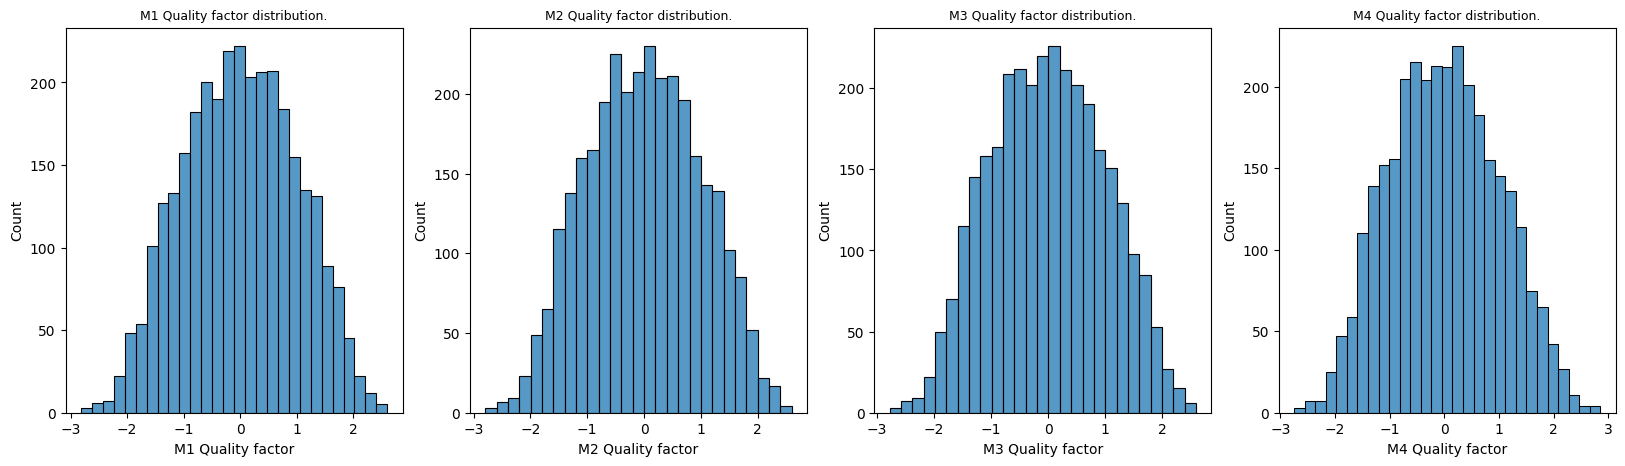

In [13]:
from classic_ml import plot_distribution

plot_distribution(df=y_train, param_name='Quality factor',
                  log_scale=False, font_size=0.25)

# Формирование подвыборок

Определение подвыборок и даталоадеров:

In [14]:
from dataset_preprocessing_torch import CustomDataset

trainset = CustomDataset(x_train, y_train)
valset = CustomDataset(x_val, y_val)
testset = CustomDataset(x_test, y_test)

batch_size = 256

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [15]:
print(len(train_loader))

13


# Модель MLP

In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [22]:
num_pars_x = x_train.shape[1]
num_pars_y = y_train.shape[1]

class FCNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=num_pars_x, out_features=1000, bias=False),
            nn.BatchNorm1d(num_features=1000),
            nn.ReLU(),
            nn.Linear(in_features=1000, out_features=200, bias=False),
            nn.BatchNorm1d(num_features=200),
            nn.ReLU(),
            nn.Linear(in_features=200, out_features=num_pars_y, bias=True),
        )

    def forward(self, x):
        out = self.network(x)
        return out

    # Инициализация весов (НЕ ИСПОЛЬЗУЕТСЯ)
    def init(self):
        relu_gain = torch.nn.init.calculate_gain('relu')
        for child in self.children():
            if isinstance(child, nn.Linear):
                if self.init_form == "normal":
                    torch.nn.init.kaiming_normal_(child.weight)

                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                elif self.init_form == "uniform":
                    torch.nn.init.kaiming_uniform_(child.weight)

                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                else:
                    raise NotImplementedError()

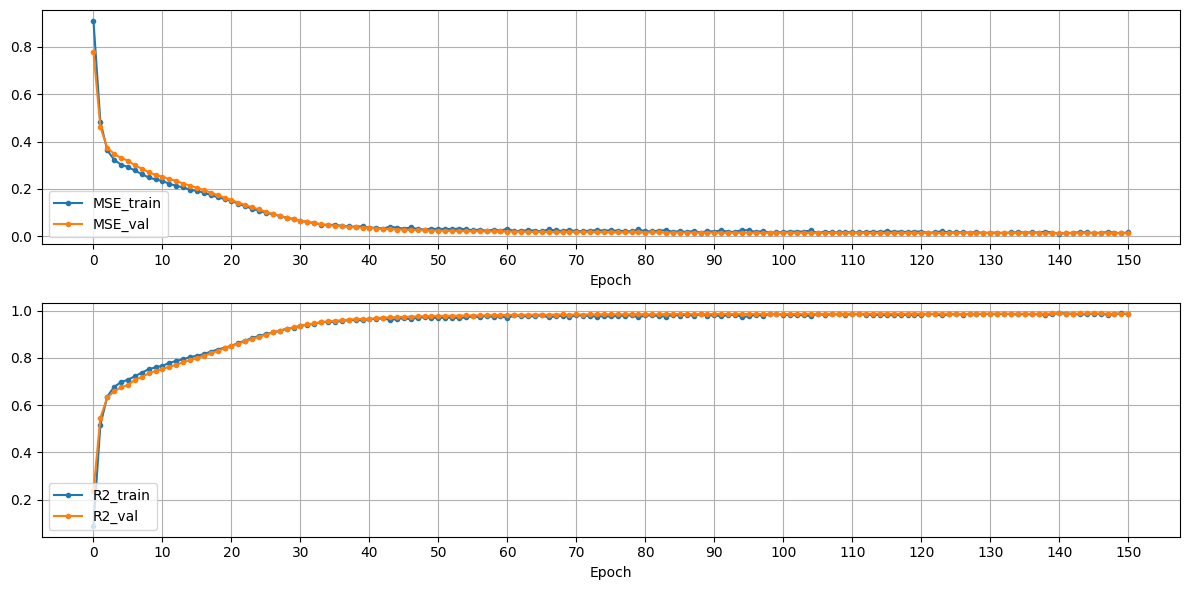

In [23]:
from neural_ml import train_mlp

model_mlp = FCNetwork().to(device)
#optimizer = torch.optim.Adam(model_mlp.parameters(), lr=1e-4)
optimizer = Lion(model_mlp.parameters(), lr=1e-4)
criterion = nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', threshold=1e-8, verbose=True)
pp_mlp = train_mlp(model_mlp, train_loader, val_loader,
                   criterion, optimizer, scheduler,
                   num_epochs=150, plot_param='M1 Quality factor')

Проверка на тестовом датасете:

In [24]:
from neural_ml import get_readable_metrics_mlp

print(get_readable_metrics_mlp(model=model_mlp, data_loader=test_loader))

{'M1 Eigenfrequency (Hz)': [0.002406823681667447, 0.9975333213806152], 'M1 Quality factor': [0.014126170426607132, 0.9847200512886047], 'M1 Effective mass (kg)': [0.002518757013604045, 0.9973797798156738], 'M1 TED (W)': [0.004390571266412735, 0.9955024719238281], 'M1 Noise (kg^2/s^3)': [0.017346633598208427, 0.9821017980575562], 'M2 Eigenfrequency (Hz)': [0.0020918515510857105, 0.9978618621826172], 'M2 Quality factor': [0.013508977368474007, 0.9854480028152466], 'M2 Effective mass (kg)': [0.0027128132060170174, 0.9971747994422913], 'M2 TED (W)': [0.004203158430755138, 0.995707631111145], 'M2 Noise (kg^2/s^3)': [0.019740037620067596, 0.9795162677764893], 'M3 Eigenfrequency (Hz)': [0.0019139193464070559, 0.9980478882789612], 'M3 Quality factor': [0.013749600388109684, 0.9852074980735779], 'M3 Effective mass (kg)': [0.0028599135112017393, 0.9970220923423767], 'M3 TED (W)': [0.004549094941467047, 0.995359480381012], 'M3 Noise (kg^2/s^3)': [0.023177048191428185, 0.9754585027694702], 'M4 Eig

# Анализ чисел Шепли

In [25]:
shap.initjs()

In [26]:
x_shap = x_test.iloc[:200, :]
x_shap_torch = torch.tensor(x_shap.values, dtype=torch.float32)


explainer = shap.DeepExplainer(model_mlp, x_shap_torch)
shap_values = explainer.shap_values(x_shap_torch)

Для получения всех графиков, представленных в курсовой работе, поочередно изменяйте `param_index` от 0 до 4. Если хотите уменьшить количество отображаемых входных параметров, то сократите количество индексов в `plot_indices`.

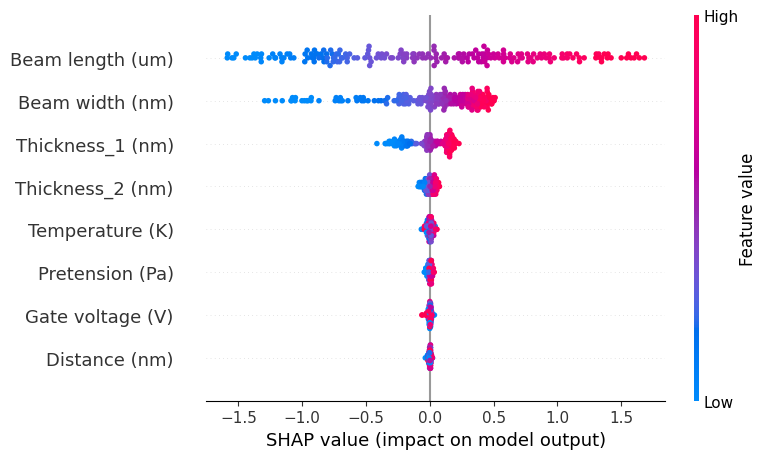

In [29]:
param_index = 2
plot_indices = [0, 1, 2, 3, 4, 5, 6, 7]

shap.summary_plot(shap_values=shap_values[param_index][:, plot_indices],
                  features=x_shap.iloc[:, plot_indices])